In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import logistic, multivariate_normal, norm
from scipy.special import expit

from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dot, Input
from keras.utils.vis_utils import model_to_dot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

from IPython.display import SVG

Using TensorFlow backend.
/Users/tiao/.virtualenvs/implicit/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
plt.style.use('seaborn-notebook')
sns.set_context('notebook')
# display animation inline
plt.rc('animation', html='html5')

In [4]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)

In [5]:
K.tf.__version__

'1.2.1'

In [6]:
LATENT_DIM = 2
NOISE_DIM = 3
BATCH_SIZE = 128
D_BATCH_SIZE = 128
G_BATCH_SIZE = 128
PRIOR_VARIANCE = 2.

In [7]:
w_min, w_max = -5, 5

In [8]:
w1, w2 = np.mgrid[w_min:w_max:300j, w_min:w_max:300j]

In [9]:
w_grid = np.dstack((w1, w2))
w_grid.shape

(300, 300, 2)

In [10]:
prior = multivariate_normal(mean=np.zeros(LATENT_DIM), 
                            cov=PRIOR_VARIANCE)

In [11]:
log_prior = prior.logpdf(w_grid)
log_prior.shape

(300, 300)

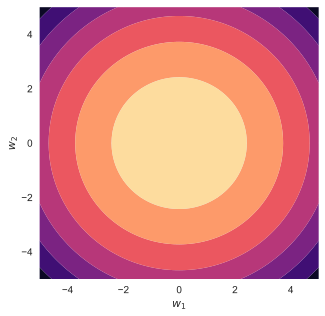

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, log_prior, cmap='magma')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [13]:
x1 = np.array([ 1.5,  1.])
x2 = np.array([-1.5,  1.])
x3 = np.array([- .5, -1.])

In [14]:
X = np.vstack((x1, x2, x3))
X.shape

(3, 2)

In [15]:
y1 = 1
y2 = 1
y3 = 0

In [16]:
y = np.stack((y1, y2, y3))
y.shape

(3,)

In [17]:
def log_likelihood(w, x, y):
    # equiv. to negative binary cross entropy
    return np.log(expit(np.dot(w.T, x)*(-1)**(1-y)))

In [18]:
llhs = log_likelihood(w_grid.T, X.T, y)
llhs.shape

(300, 300, 3)

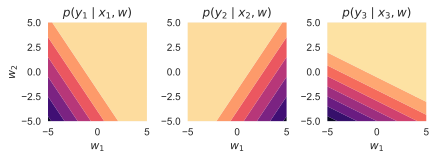

In [19]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(6, 2))
fig.tight_layout()

for i, ax in enumerate(axes):
    
    ax.contourf(w1, w2, llhs[::,::,i], cmap=plt.cm.magma)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(w_min, w_max)
    
    ax.set_title('$p(y_{{{0}}} \mid x_{{{0}}}, w)$'.format(i+1))
    ax.set_xlabel('$w_1$')    
    
    if not i:
        ax.set_ylabel('$w_2$')

plt.show()

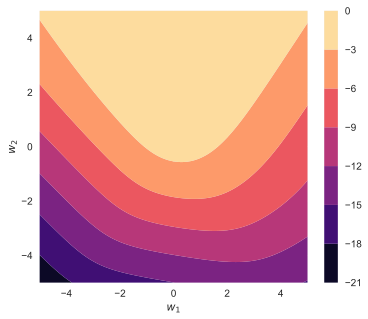

In [20]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, np.sum(llhs, axis=2), 
                cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

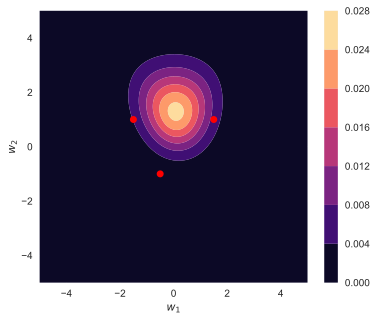

In [21]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, 
                np.exp(log_prior+np.sum(llhs, axis=2)), 
                cmap=plt.cm.magma)
ax.plot(*np.vstack((x1,x2,x3)).T, 'ro')

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

## Model Definitions

### Density Ratio Estimator (Discriminator) Model

$T_{\psi}(x, z)$

Here we consider

$T_{\psi}(w)$

$T_{\psi} : \mathbb{R}^2 \to \mathbb{R}$

In [22]:
discriminator = Sequential(name='discriminator')
discriminator.add(Dense(10, input_dim=LATENT_DIM, activation='relu'))
discriminator.add(Dense(20, activation='relu'))
discriminator.add(Dense(1, activation=None, name='logit'))
discriminator.add(Activation('sigmoid'))
discriminator.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

In [23]:
ratio_estimator = Model(
    inputs=discriminator.inputs, 
    outputs=discriminator.get_layer(name='logit').output)

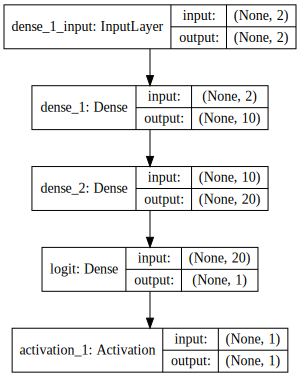

In [24]:
SVG(model_to_dot(discriminator, show_shapes=True)
    .create(prog='dot', format='svg'))

In [25]:
w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

Initial density ratio, prior to any training

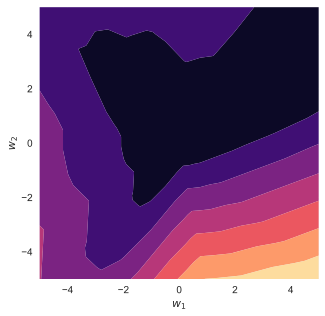

In [26]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.show()

In [27]:
discriminator.evaluate(prior.rvs(size=5), np.zeros(5))

5/5 [==============================] - 0s


[0.82634639739990234, 0.0]

### Approximate Inference Model

$z_{\phi}(x, \epsilon)$

Here we only consider

$z_{\phi}(\epsilon)$

$z_{\phi}: \mathbb{R}^3 \to \mathbb{R}^2$

In [28]:
inference = Sequential()
inference.add(Dense(10, input_dim=NOISE_DIM, activation='relu'))
inference.add(Dense(20, activation='relu'))
inference.add(Dense(LATENT_DIM, activation=None))
inference.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


The variational parameters $\phi$ are the trainable weights of the approximate inference model

In [29]:
phi = inference.trainable_weights
phi

[<tf.Variable 'dense_3/kernel:0' shape=(3, 10) dtype=float32_ref>,
 <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'dense_4/kernel:0' shape=(10, 20) dtype=float32_ref>,
 <tf.Variable 'dense_4/bias:0' shape=(20,) dtype=float32_ref>,
 <tf.Variable 'dense_5/kernel:0' shape=(20, 2) dtype=float32_ref>,
 <tf.Variable 'dense_5/bias:0' shape=(2,) dtype=float32_ref>]

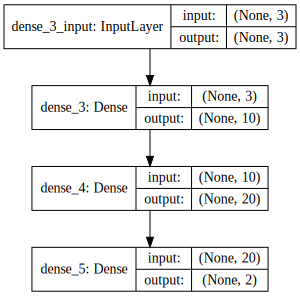

In [30]:
SVG(model_to_dot(inference, show_shapes=True)
    .create(prog='dot', format='svg'))

In [31]:
eps = np.random.randn(BATCH_SIZE, NOISE_DIM)

In [32]:
w_posterior_samples = inference.predict(eps)
w_posterior_samples.shape

(128, 2)

In [33]:
w_prior_samples = prior.rvs(size=BATCH_SIZE)
w_prior_samples.shape

(128, 2)

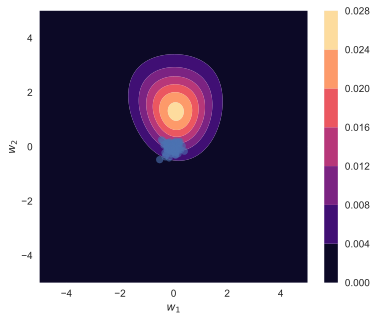

In [34]:
fig, ax = plt.subplots(figsize=(6, 5))

c = ax.contourf(w1, w2, 
                np.exp(log_prior+np.sum(llhs, axis=2)), 
                cmap=plt.cm.magma)

ax.scatter(*w_posterior_samples.T, alpha=.6)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

plt.colorbar(c)
plt.show()

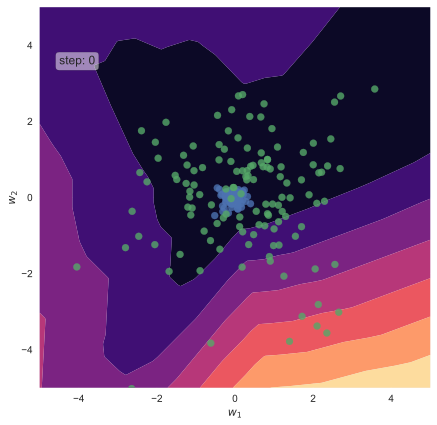

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma, animate=True)

scatter_posterior = ax.scatter(*w_posterior_samples.T, alpha=.8)
scatter_prior = ax.scatter(*w_prior_samples.T, alpha=.8)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

t = ax.text(0.05, 0.85, 'step: 0', 
            transform=ax.transAxes, bbox=props)

plt.show()

In [36]:
def animate(step):

    ax.cla()

    w_prior_samples = prior.rvs(size=BATCH_SIZE)

    eps = np.random.randn(BATCH_SIZE, NOISE_DIM)
    w_posterior_samples = inference.predict(eps)
    
#     scatter_prior.set_offsets(w_prior_samples)
#     scatter_posterior.set_offsets(w_posterior_samples)

    D_input = np.vstack((w_posterior_samples, w_prior_samples))
    D_labels = np.hstack((np.ones(w_posterior_samples.shape[0]),
                          np.zeros(w_prior_samples.shape[0])))

    metrics = discriminator.train_on_batch(D_input, D_labels)

    w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
    w_grid_ratio = w_grid_ratio.reshape(300, 300)
    
    cset = ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma, animate=True)

    info_dict = dict(zip(discriminator.metrics_names, metrics))
    info_dict['step'] = step

    props = dict(boxstyle='round', facecolor='w', alpha=0.5)

    t = ax.text(0.05, 0.85, 'step: 0', 
                transform=ax.transAxes, bbox=props)

    scatter_posterior = ax.scatter(*w_posterior_samples.T, alpha=.8)
    scatter_prior = ax.scatter(*w_prior_samples.T, alpha=.8)
    
    return ax

In [37]:
FuncAnimation(fig, animate, frames=50, 
              interval=200, # 5 fps
              blit=False)

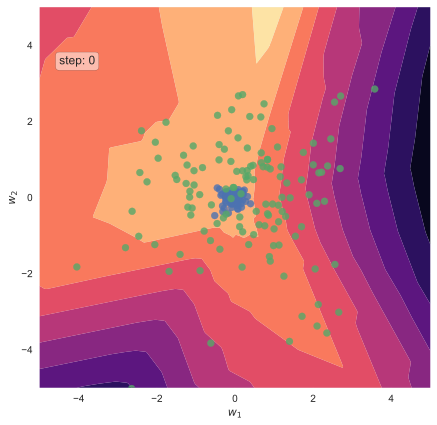

In [38]:
fig, ax = plt.subplots(figsize=(7, 7))

w_grid_ratio = ratio_estimator.predict(w_grid.reshape(300*300, 2))
w_grid_ratio = w_grid_ratio.reshape(300, 300)

cset = ax.contourf(w1, w2, w_grid_ratio, cmap=plt.cm.magma, animate=True)

scatter_posterior = ax.scatter(*w_posterior_samples.T, alpha=.8)
scatter_prior = ax.scatter(*w_prior_samples.T, alpha=.8)

ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')

ax.set_xlim(w_min, w_max)
ax.set_ylim(w_min, w_max)

props = dict(boxstyle='round', facecolor='w', alpha=0.5)

t = ax.text(0.05, 0.85, 'step: 0', 
            transform=ax.transAxes, bbox=props)

plt.show()

In [39]:
cset.collections

<a list of 9 mcoll.PathCollection objects>

In [40]:
from matplotlib.collections import PatchCollection

In [41]:
dir(cset.collections[0])

['_A',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_antialiaseds',
 '_axes',
 '_bcast_lwls',
 '_clipon',
 '_clippath',
 '_contains',
 '_edge_default',
 '_edgecolors',
 '_facecolors',
 '_factor',
 '_get_bool',
 '_get_value',
 '_gid',
 '_hatch',
 '_hatch_color',
 '_is_filled',
 '_is_stroked',
 '_label',
 '_linestyles',
 '_linewidths',
 '_mouseover',
 '_offset_position',
 '_offsets',
 '_oid',
 '_original_edgecolor',
 '_original_facecolor',
 '_path_effects',
 '_paths',
 '_picker',
 '_pickradius',
 '_prepare_points',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_set_edgecolor',
 '_set_

In [42]:
import matplotlib.patches as patches


In [43]:
from matplotlib.collections import PathCollection

RuntimeError: Can not put single artist in more than one figure

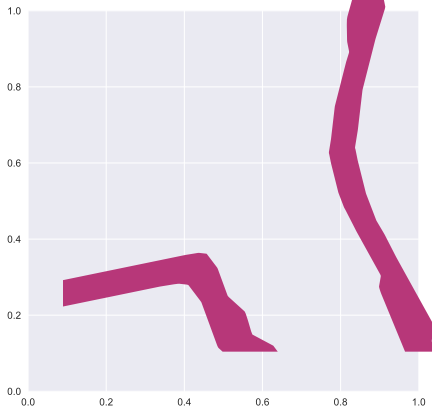

In [44]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.add_collection(cset.collections[4])

plt.show()